# Machine Learning for Networking - Group Project 5 - DDoS attacks detection and characterization - Section 1
# Import the dataset

In [1]:
# import needed python libraries

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


In [2]:
# load dataset
ddos_data = pd.read_csv("ddos_dataset.csv", sep=",", dtype={'SimillarHTTP': str})
ddos_data.rename(columns=lambda x: x.strip(), inplace=True)
columns = ddos_data.columns

In [3]:
ddos_data

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,label
0,0,172.16.0.5-192.168.50.1-634-60495-17,172.16.0.5,634,192.168.50.1,60495,17,2018-12-01 10:51:39.813448,28415,97,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
1,1,172.16.0.5-192.168.50.1-60495-634-17,192.168.50.1,634,172.16.0.5,60495,17,2018-12-01 10:51:39.820842,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,ddos_dns
2,2,172.16.0.5-192.168.50.1-634-46391-17,172.16.0.5,634,192.168.50.1,46391,17,2018-12-01 10:51:39.852499,48549,200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
3,3,172.16.0.5-192.168.50.1-634-11894-17,172.16.0.5,634,192.168.50.1,11894,17,2018-12-01 10:51:39.890213,48337,200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
4,4,172.16.0.5-192.168.50.1-634-27878-17,172.16.0.5,634,192.168.50.1,27878,17,2018-12-01 10:51:39.941151,32026,200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64234,65995,172.16.0.5-192.168.50.1-38625-63051-17,172.16.0.5,38625,192.168.50.1,63051,17,2018-12-01 13:04:46.628249,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
64235,65996,172.16.0.5-192.168.50.1-58632-18963-17,172.16.0.5,58632,192.168.50.1,18963,17,2018-12-01 13:04:46.628963,212238,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
64236,65997,172.16.0.5-192.168.50.1-46104-64704-17,172.16.0.5,46104,192.168.50.1,64704,17,2018-12-01 13:04:46.629014,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
64237,65998,172.16.0.5-192.168.50.1-60686-10440-17,172.16.0.5,60686,192.168.50.1,10440,17,2018-12-01 13:04:46.629016,108952,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag


# Clean the Dataset

***From the specifications***: *"Flow ID: a unique identifier for each flow of network traffic in the dataset"*<br>
***Question***: Is a Flow ID unique or can it be repeated?

In [4]:
ddos_data["Flow ID"].value_counts()

172.16.0.5-192.168.50.1-0-0-0             18
192.168.50.253-224.0.0.5-0-0-0            14
192.168.50.254-224.0.0.5-0-0-0            14
8.0.6.4-8.6.0.1-0-0-0                     12
172.16.0.5-192.168.50.1-9553-22-6          9
                                          ..
172.16.0.5-192.168.50.1-36404-21981-17     1
172.16.0.5-192.168.50.1-36405-46365-17     1
172.16.0.5-192.168.50.1-61850-24027-17     1
172.16.0.5-192.168.50.1-61850-6932-17      1
172.16.0.5-192.168.50.1-45602-1387-17      1
Name: Flow ID, Length: 60958, dtype: int64

**Watch out:** <br>While analyzing the provided dataset, we encountered an error related to data quality issues, specifically that the flow ID sometimes does not adhere to the standard format. As a result of this, We deemed it necessary to remove the current flow ID and generate a new one of our own.
* Flow ID is the combination of: source IP - destination ip - source port - destination port - protocol

In [5]:
ddos_data["Flow ID"] = ( ddos_data['Source IP'].astype(str) + ' - ' +
                         ddos_data['Source Port'].astype(str) + ' - ' +
                         ddos_data['Destination IP'].astype(str) + ' - ' + 
                         ddos_data['Destination Port'].astype(str) ) 
ddos_data["Flow ID"].value_counts()

172.16.0.5 - 0 - 192.168.50.1 - 0            18
192.168.50.253 - 0 - 224.0.0.5 - 0           14
192.168.50.254 - 0 - 224.0.0.5 - 0           14
8.6.0.1 - 0 - 8.0.6.4 - 0                    12
192.168.50.7 - 50107 - 52.173.24.17 - 443     9
                                             ..
172.16.0.5 - 36603 - 192.168.50.1 - 44950     1
172.16.0.5 - 36604 - 192.168.50.1 - 9261      1
172.16.0.5 - 36605 - 192.168.50.1 - 3322      1
172.16.0.5 - 36606 - 192.168.50.1 - 3631      1
172.16.0.5 - 45602 - 192.168.50.1 - 1387      1
Name: Flow ID, Length: 62154, dtype: int64

We expected a flow ID to be unique, but indeed, a certain flow can be repeated. Let's consider an individual accessing a service daily; each day, the flow ID remains the same. What we expect to be unique for each sample is the combination: Flow ID + Timestamp.

In [6]:
ddos_data["Flow ID"] = ( ddos_data['Source IP'].astype(str) + ' - ' +
                         ddos_data['Source Port'].astype(str) + ' - ' +
                         ddos_data['Destination IP'].astype(str) + ' - ' + 
                         ddos_data['Destination Port'].astype(str) + ' - ' + 
                         ddos_data['Timestamp'].astype(str) ) 

# By running this instruction ( and commenting on the next one) you can see that Flow ID + Timestamp are unique
# ddos_data["Flow ID"].value_counts()
ddos_data = ddos_data.set_index("Flow ID")

***Our hypothesis is correct.***

Cleaning features that do not provide information and can be removed:
* Numerical Index Unnamed 

Identified categorical features
* Simillar HTTP

In [7]:
ddos_data.drop("Unnamed: 0", axis=1, inplace=True)

ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].astype(str).str.strip()
ddos_data['SimillarHTTP'] = pd.Categorical(ddos_data['SimillarHTTP']).codes


We notice that many columns have the same value 0 for all samples, therefore they have zero variance and can be eliminated because they do not provide any information.

In [8]:
# Variance for each column
variance = ddos_data.var(numeric_only=True)

# Find columns with zero variance
zero_variance = variance[variance == 0].index

# Remove these columns from the DataFrame
ddos_data.drop(zero_variance, axis=1, inplace=True)
ddos_data

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,label
Flow ID,,,,,,,,,,,,,,,,,,,,,
172.16.0.5 - 634 - 192.168.50.1 - 60495 - 2018-12-01 10:51:39.813448,172.16.0.5,634,192.168.50.1,60495,17,2018-12-01 10:51:39.813448,28415,97,0,42680.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
192.168.50.1 - 634 - 172.16.0.5 - 60495 - 2018-12-01 10:51:39.820842,192.168.50.1,634,172.16.0.5,60495,17,2018-12-01 10:51:39.820842,2,2,0,880.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,ddos_dns
172.16.0.5 - 634 - 192.168.50.1 - 46391 - 2018-12-01 10:51:39.852499,172.16.0.5,634,192.168.50.1,46391,17,2018-12-01 10:51:39.852499,48549,200,0,88000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
172.16.0.5 - 634 - 192.168.50.1 - 11894 - 2018-12-01 10:51:39.890213,172.16.0.5,634,192.168.50.1,11894,17,2018-12-01 10:51:39.890213,48337,200,0,88000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
172.16.0.5 - 634 - 192.168.50.1 - 27878 - 2018-12-01 10:51:39.941151,172.16.0.5,634,192.168.50.1,27878,17,2018-12-01 10:51:39.941151,32026,200,0,88000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172.16.0.5 - 38625 - 192.168.50.1 - 63051 - 2018-12-01 13:04:46.628249,172.16.0.5,38625,192.168.50.1,63051,17,2018-12-01 13:04:46.628249,1,2,0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
172.16.0.5 - 58632 - 192.168.50.1 - 18963 - 2018-12-01 13:04:46.628963,172.16.0.5,58632,192.168.50.1,18963,17,2018-12-01 13:04:46.628963,212238,6,0,2088.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
172.16.0.5 - 46104 - 192.168.50.1 - 64704 - 2018-12-01 13:04:46.629014,172.16.0.5,46104,192.168.50.1,64704,17,2018-12-01 13:04:46.629014,1,2,0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag


 # Visualizations and statistical analysis

## Generic traffic level

### IP distribution

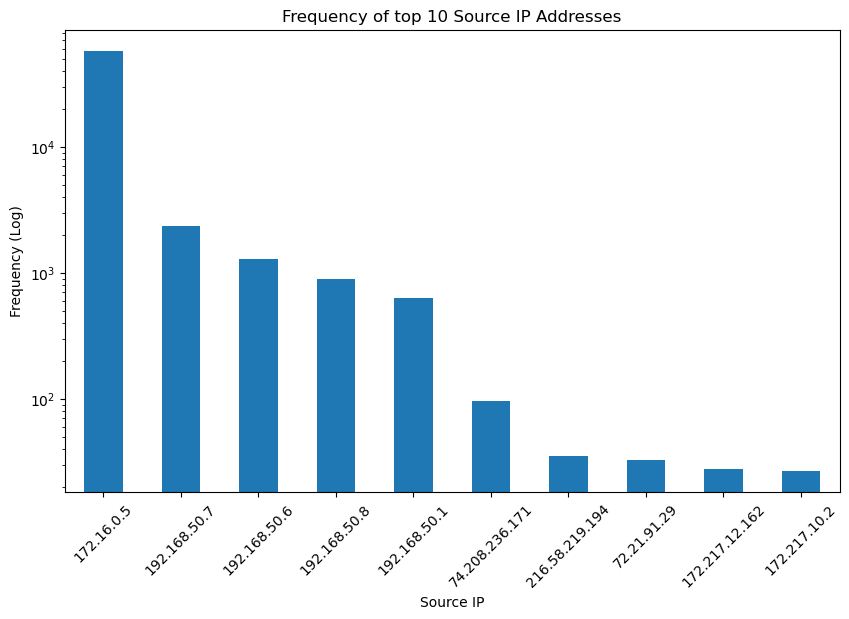

In [9]:
source_ip_count = ddos_data['Source IP'].value_counts().head(10)

plt.figure(figsize=(10, 6)) 
source_ip_count.plot(kind='bar', logy=True) 
plt.title('Frequency of top 10 Source IP Addresses')
plt.xlabel('Source IP')
plt.xticks(rotation=45)
plt.ylabel('Frequency (Log)')
plt.show()

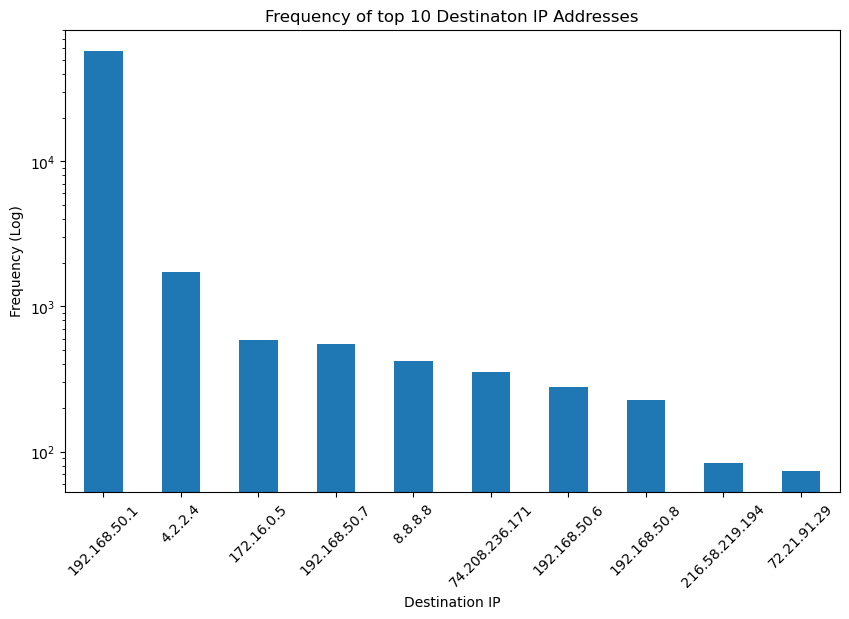

In [10]:
destination_ip_count = ddos_data['Destination IP'].value_counts().head(10)

plt.figure(figsize=(10, 6))  
destination_ip_count.plot(kind='bar', logy=True) 
plt.title('Frequency of top 10 Destinaton IP Addresses')
plt.xlabel('Destination IP')
plt.xticks(rotation=45)
plt.ylabel('Frequency (Log)')
plt.show()

<Figure size 1400x800 with 0 Axes>

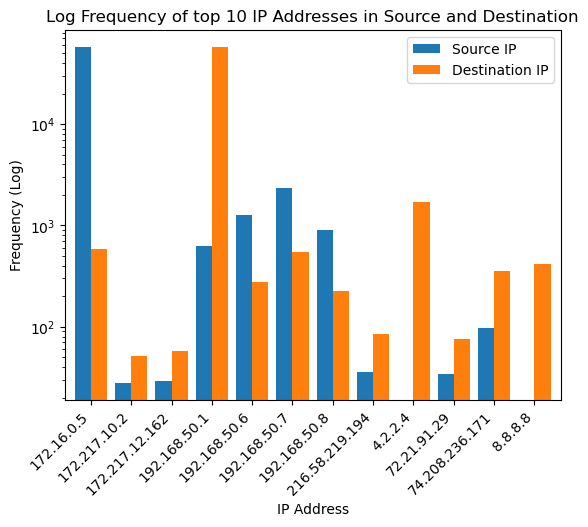

In [11]:
# Calculate counts for source and destination IPs
source_ip_count = ddos_data['Source IP'].value_counts()
destination_ip_count = ddos_data['Destination IP'].value_counts()

# Extract the top 10 IPs for both source and destination
top_10_source_ip = source_ip_count.head(10)
top_10_destination_ip = destination_ip_count.head(10)

# Combine both top 10 IP sets to ensure all are represented
combined_ips = top_10_source_ip.index.union(top_10_destination_ip.index)

# Create a DataFrame mapping each IP to its source and destination counts
combined_ip_count = pd.DataFrame({
    'Source IP': source_ip_count,
    'Destination IP': destination_ip_count
}).reindex(combined_ips)

# Use combine_first to fill in missing source and destination counts
combined_ip_count['Source IP'] = combined_ip_count['Source IP'].combine_first(source_ip_count)
combined_ip_count['Destination IP'] = combined_ip_count['Destination IP'].combine_first(destination_ip_count)

# Add 1 to avoid log(0) in transformation
combined_ip_count += 1


# Plot 
plt.figure(figsize=(14, 8))  # Adjust figure size as needed
ax = combined_ip_count.plot(kind='bar', logy=True, width=0.8)
plt.title('Log Frequency of top 10 IP Addresses in Source and Destination')
plt.xlabel('IP Address')
plt.ylabel('Frequency (Log)')
plt.xticks(rotation=45, ha='right')  # ha is the horizontal alignment
plt.show()


### Incoming and outgoing flows distribution

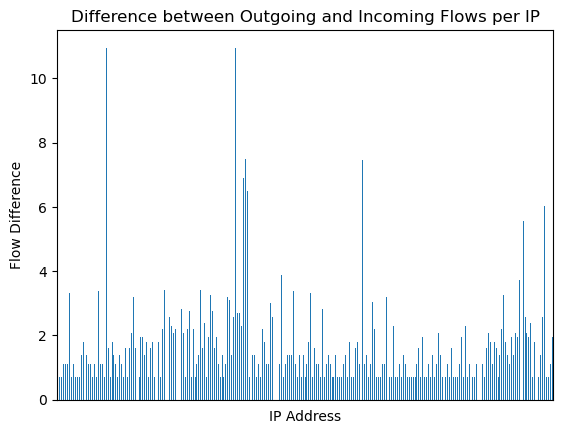

In [12]:
incoming_flows = ddos_data['Destination IP'].value_counts()
outgoing_flows = ddos_data['Source IP'].value_counts()
flow_difference = outgoing_flows.subtract(incoming_flows, fill_value=0)
flow_difference_log = np.log(flow_difference.abs()+1)

flow_difference_log.plot(kind='bar')
plt.title('Difference between Outgoing and Incoming Flows per IP')
plt.xlabel('IP Address')
plt.xticks([]) 
plt.ylabel('Flow Difference')
plt.show()

### Flow duration distribution of IPs

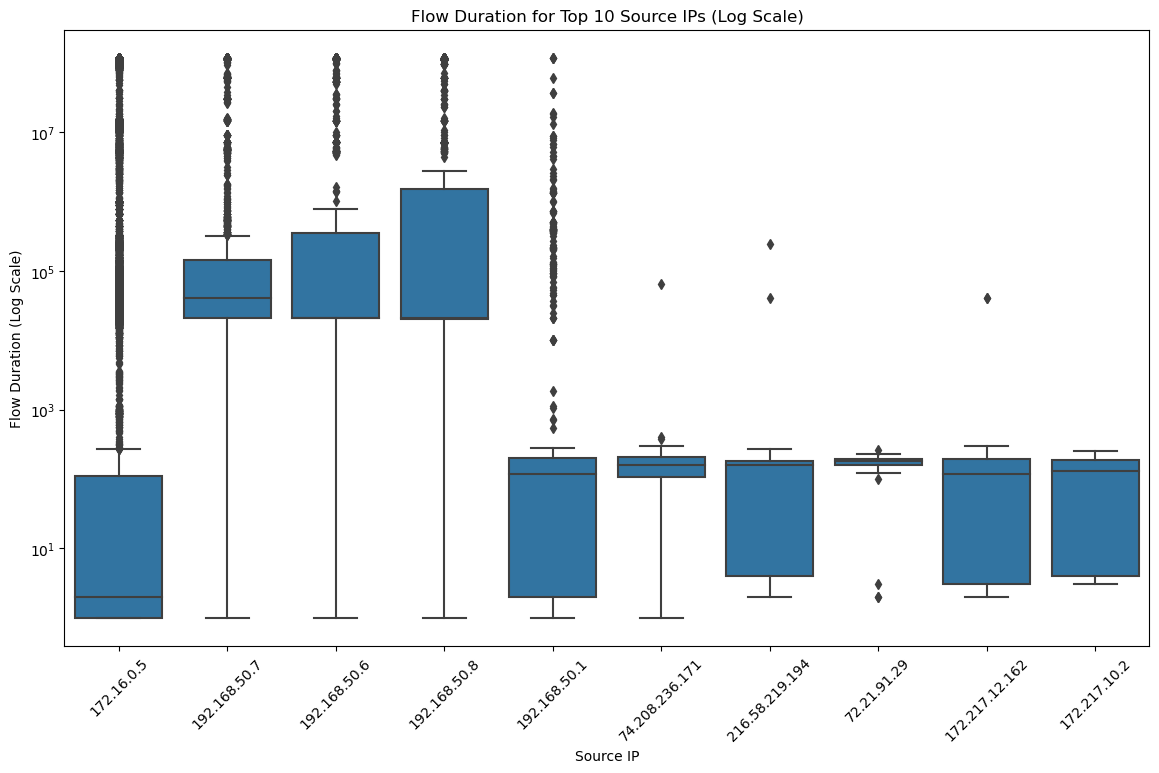

In [13]:
# Calculate the top 10 destination IP addresses.
top_destination_ips = ddos_data['Source IP'].value_counts().head(10).index

# Filter the DataFrame to include only records with the top 10 destination IP addresses.
top_destination_data = ddos_data[ddos_data['Source IP'].isin(top_destination_ips)]

plt.figure(figsize=(14, 8))  
sns.boxplot(x='Source IP', y='Flow Duration', data=top_destination_data, order=top_destination_ips, color='#1f77b4')
plt.title('Flow Duration for Top 10 Source IPs (Log Scale)')
plt.xlabel('Source IP')
plt.ylabel('Flow Duration (Log Scale)')
plt.xticks(rotation=45) 
plt.yscale('log')
plt.show()

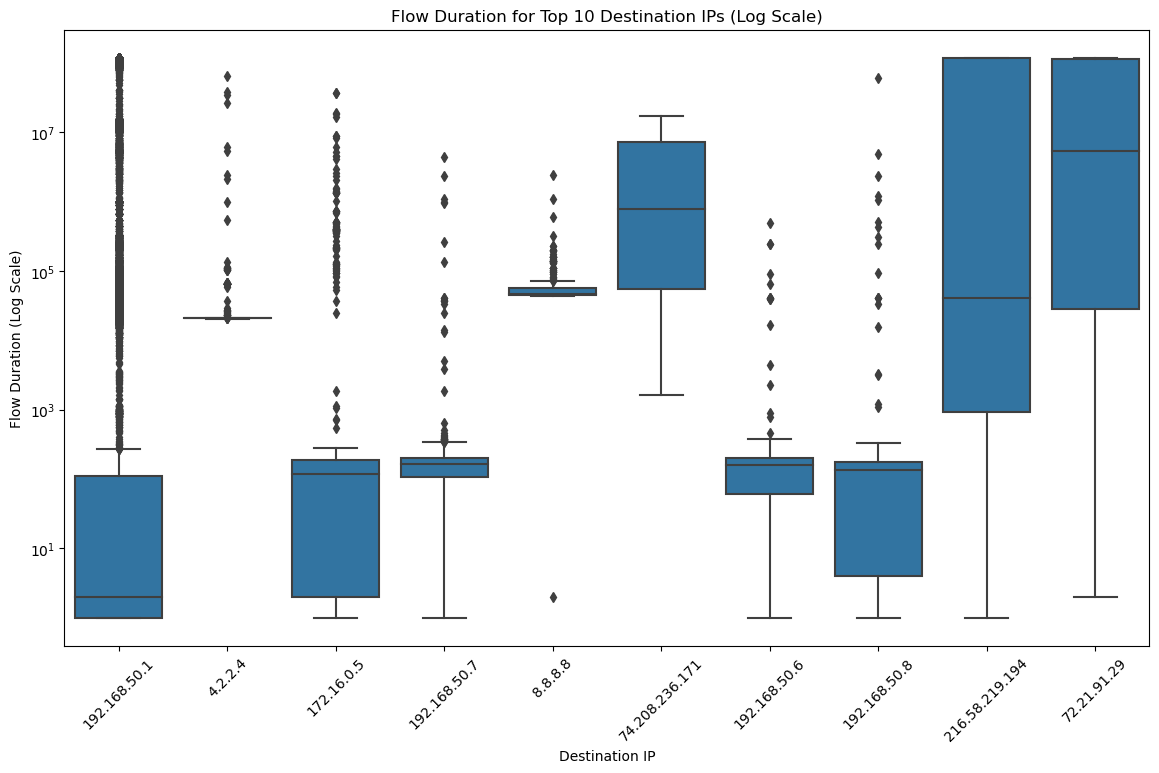

In [14]:
top_destination_ips = ddos_data['Destination IP'].value_counts().head(10).index
top_destination_data = ddos_data[ddos_data['Destination IP'].isin(top_destination_ips)]


plt.figure(figsize=(14, 8))  
sns.boxplot(x='Destination IP', y='Flow Duration', data=top_destination_data, order=top_destination_ips, color='#1f77b4')

plt.title('Flow Duration for Top 10 Destination IPs (Log Scale)')
plt.xlabel('Destination IP')
plt.ylabel('Flow Duration (Log Scale)')
plt.xticks(rotation=45)  
plt.yscale('log')

plt.show()


### Port distribution

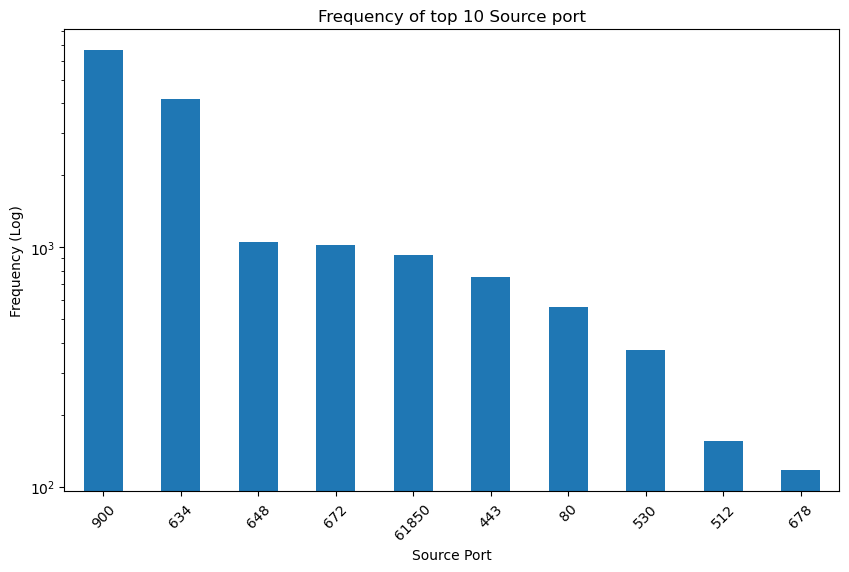

In [15]:
source_ip_count = ddos_data['Source Port'].value_counts().head(10)

plt.figure(figsize=(10, 6)) 
source_ip_count.plot(kind='bar', logy=True)  
plt.title('Frequency of top 10 Source port')
plt.xlabel('Source Port')
plt.xticks(rotation=45)
plt.ylabel('Frequency (Log)')
plt.show() 

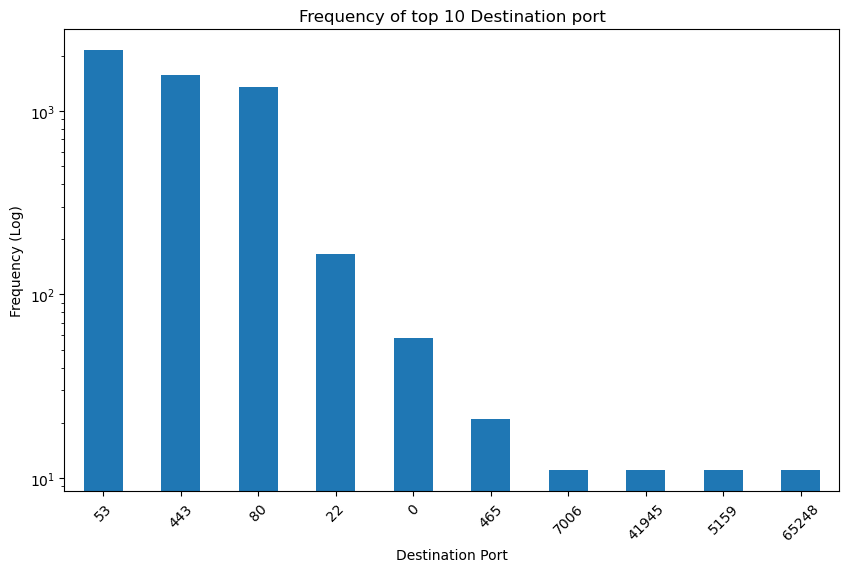

In [16]:
source_ip_count = ddos_data['Destination Port'].value_counts().head(10)

plt.figure(figsize=(10, 6)) 
source_ip_count.plot(kind='bar', logy=True)  
plt.title('Frequency of top 10 Destination port')
plt.xlabel('Destination Port')
plt.xticks(rotation=45)
plt.ylabel('Frequency (Log)')
plt.show()

### Flow duration distribution of ports

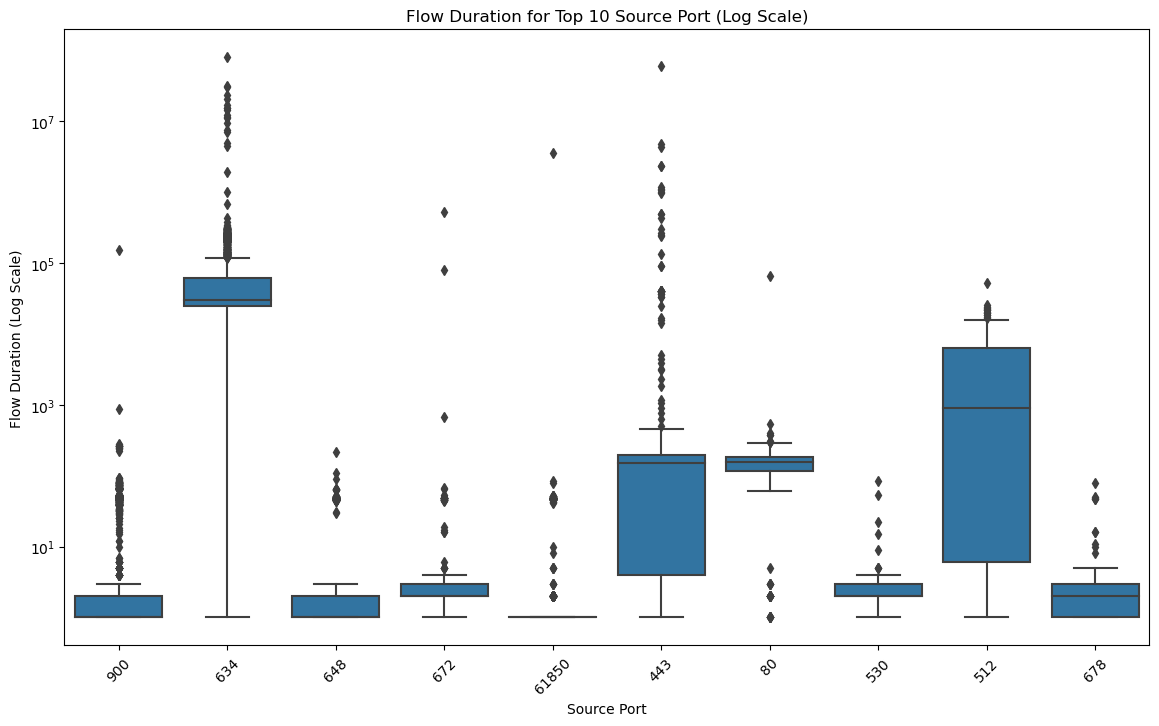

In [17]:
top_source_ports = ddos_data['Source Port'].value_counts().head(10).index
top_ource_data = ddos_data[ddos_data['Source Port'].isin(top_source_ports)]

plt.figure(figsize=(14, 8)) 
sns.boxplot(x='Source Port', y='Flow Duration', data=top_ource_data, order=top_source_ports, color='#1f77b4')
plt.title('Flow Duration for Top 10 Source Port (Log Scale)')
plt.xlabel('Source Port')
plt.ylabel('Flow Duration (Log Scale)')
plt.xticks(rotation=45)  
plt.yscale('log')
plt.show()

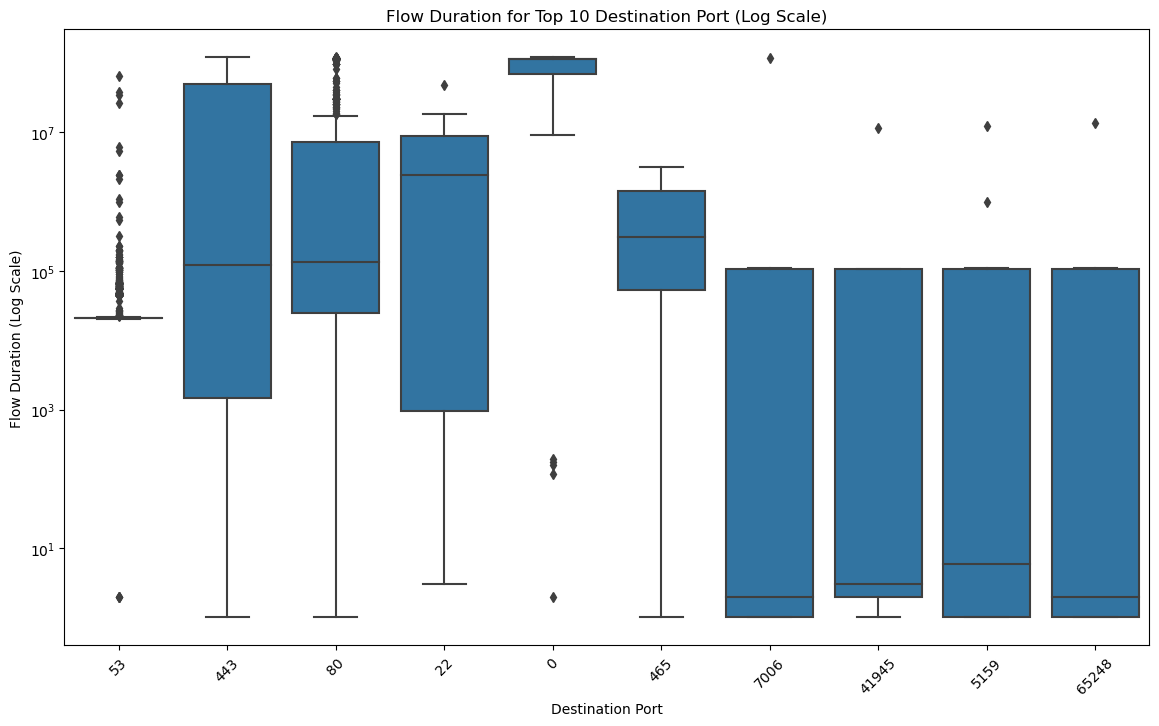

In [18]:
top_destination_ports = ddos_data['Destination Port'].value_counts().head(10).index
top_destination_data = ddos_data[ddos_data['Destination Port'].isin(top_destination_ports)]

plt.figure(figsize=(14, 8)) 
sns.boxplot(x='Destination Port', y='Flow Duration', data=top_destination_data, order=top_destination_ports, color='#1f77b4')
plt.title('Flow Duration for Top 10 Destination Port (Log Scale)')
plt.xlabel('Destination Port')
plt.ylabel('Flow Duration (Log Scale)')
plt.xticks(rotation=45)  
plt.yscale('log')
plt.show()

### Timestamp distribution

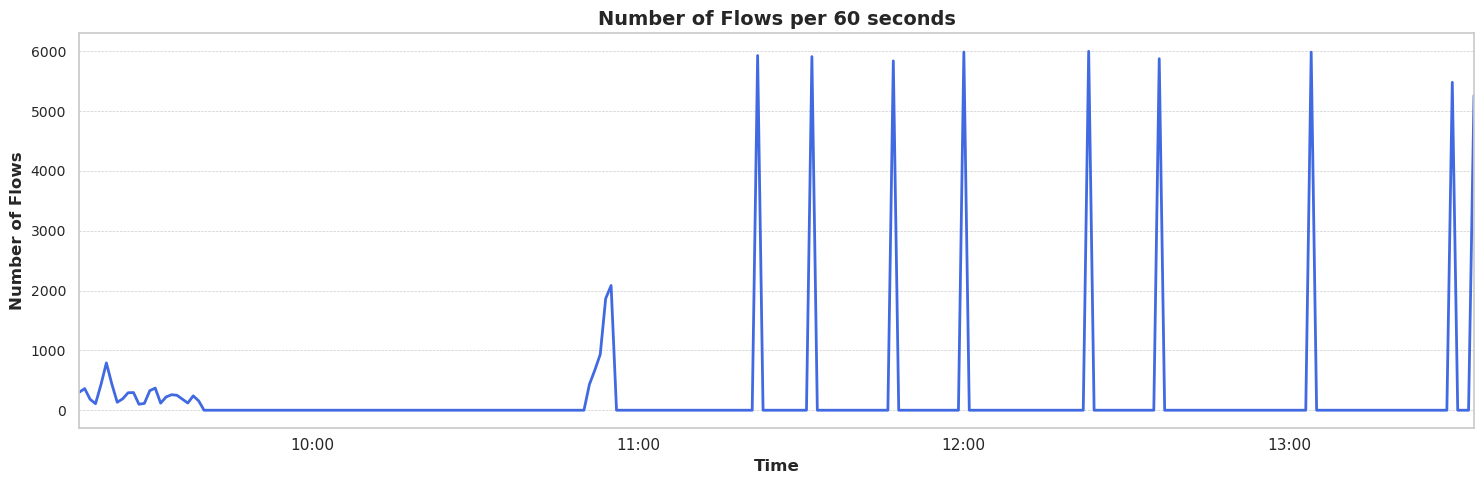

In [19]:
ddos_data_cp = ddos_data.copy()
ddos_data_cp = ddos_data_cp.reset_index()
ddos_data_cp['Timestamp'] = pd.to_datetime(ddos_data_cp['Timestamp'])
ddos_data_cp.set_index('Timestamp', inplace=True)

num_sec = 60
df_result = ddos_data_cp.resample(f'{num_sec}S').count()

sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))
df_result['Flow ID'].plot(color='royalblue', linewidth=2)
plt.xlabel('Time', fontsize=12, fontweight='bold')
plt.ylabel('Number of Flows', fontsize=12, fontweight='bold')
plt.title(f'Number of Flows per {num_sec} seconds', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


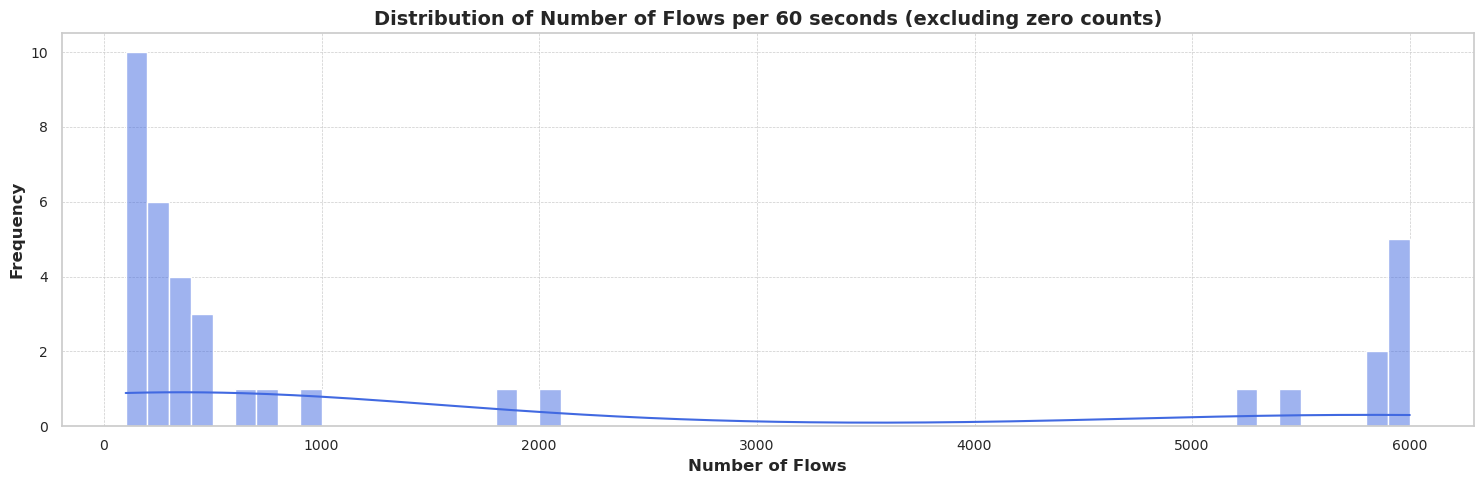

In [20]:
# Graph of distribution excluding zero flow counts.
filtered_df_result = df_result[df_result['Flow ID'] > 0] 

plt.figure(figsize=(15, 5))
sns.histplot(data=filtered_df_result, x='Flow ID', kde=True, color='royalblue', binwidth=100) 
plt.xlabel('Number of Flows', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title(f'Distribution of Number of Flows per {num_sec} seconds (excluding zero counts)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## Ground truth  level

### Label distribution

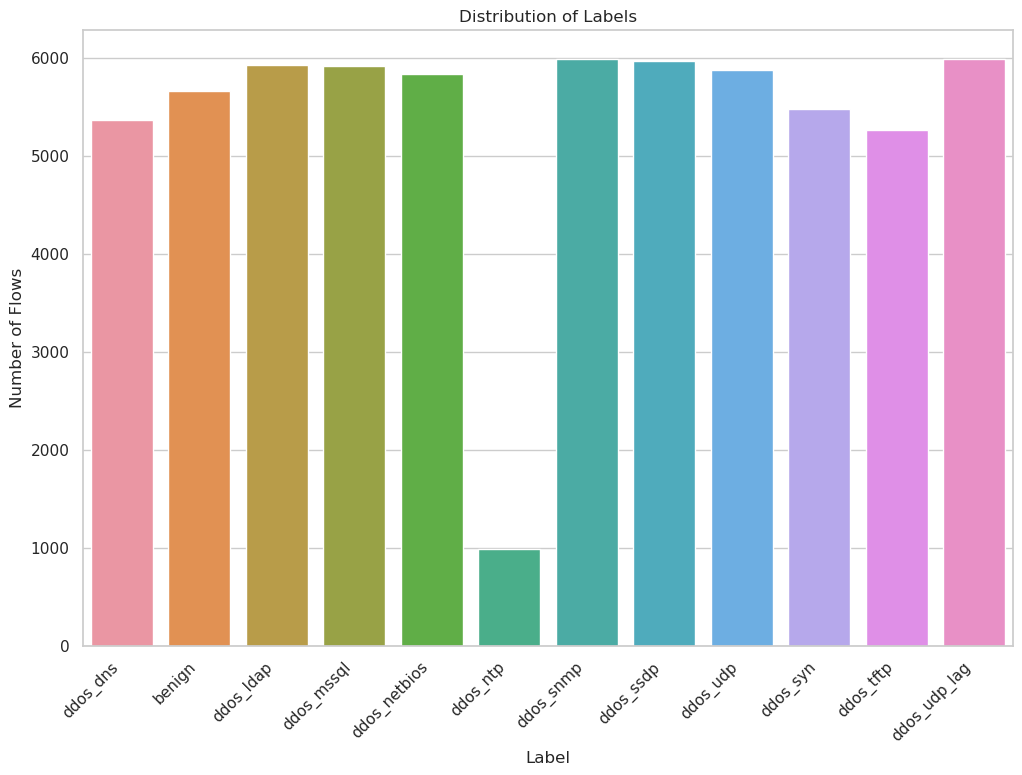

In [21]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
sns.countplot(x="label", data=ddos_data)
plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Number of Flows")
plt.xticks(rotation=45, ha='right')
plt.show()


### Port distribution

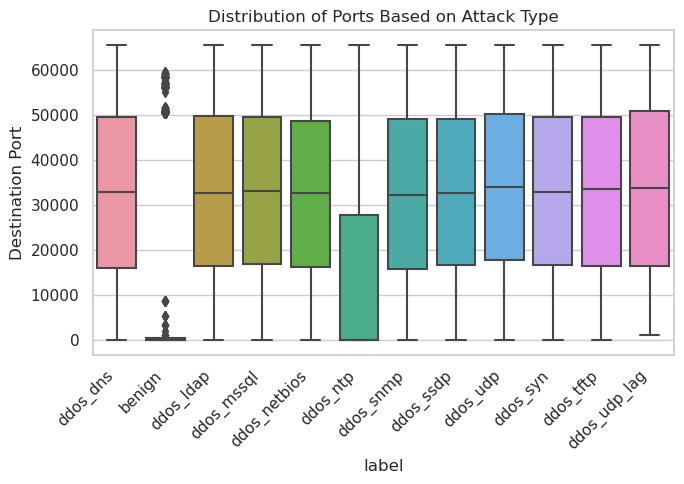

In [22]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=ddos_data, x='label', y='Destination Port')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Distribution of Ports Based on Attack Type')
plt.tight_layout()
plt.show()


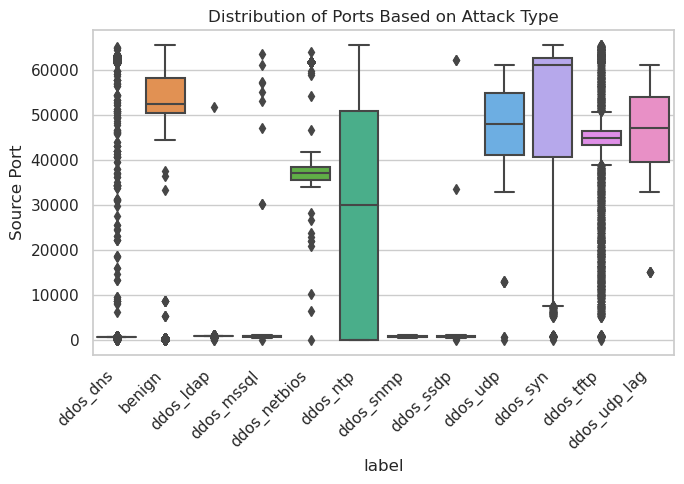

In [23]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=ddos_data, x='label', y='Source Port')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Distribution of Ports Based on Attack Type')
plt.tight_layout()
plt.show()


### Flow duration distribution of ports

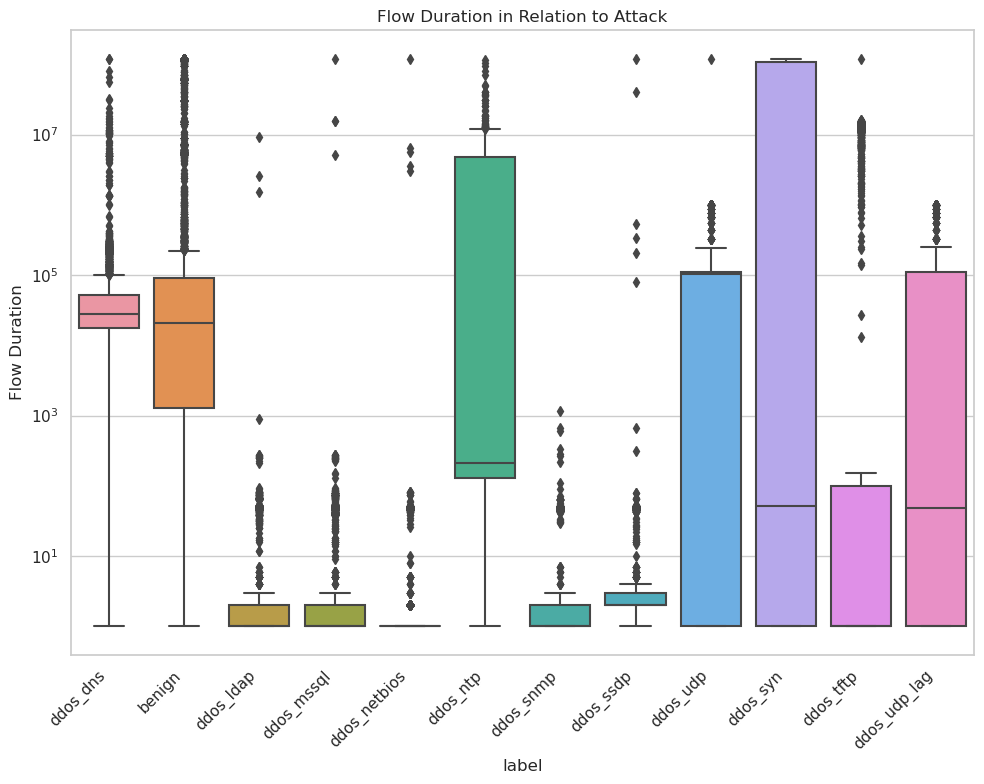

In [24]:
plt.figure(figsize=(10, 8))
ax = sns.boxplot(data=ddos_data, x='label', y='Flow Duration')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')  # Rotate the labels
ax.set_yscale('log')  # logarithmic scale
ax.set_title('Flow Duration in Relation to Attack')
plt.tight_layout()  #
plt.show()


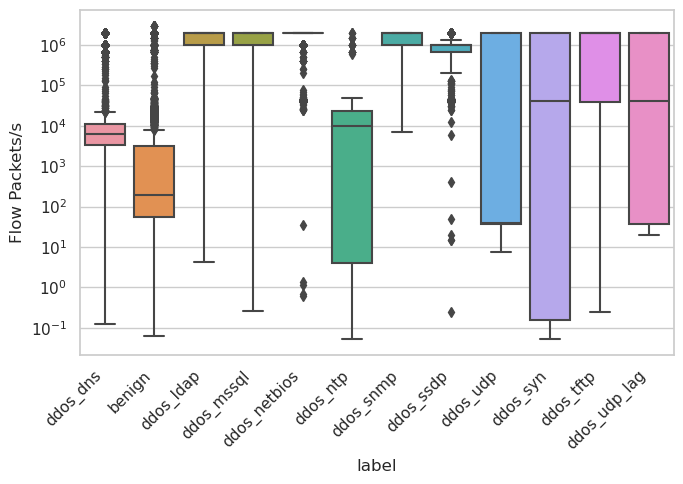

In [25]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=ddos_data, x='label', y='Flow Packets/s')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yscale('log', base=10)
plt.tight_layout()
plt.show()

### Distribution of Packets Forwarded per Flow

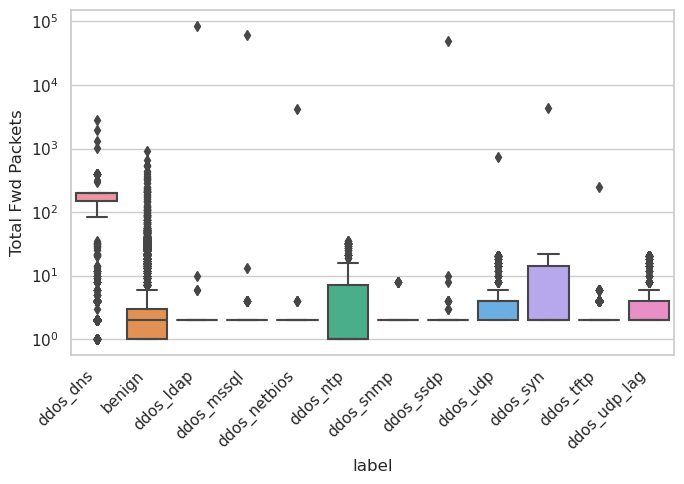

In [26]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=ddos_data, x='label', y='Total Fwd Packets')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yscale('log')
plt.tight_layout()
plt.show()

### Timestamp distribution

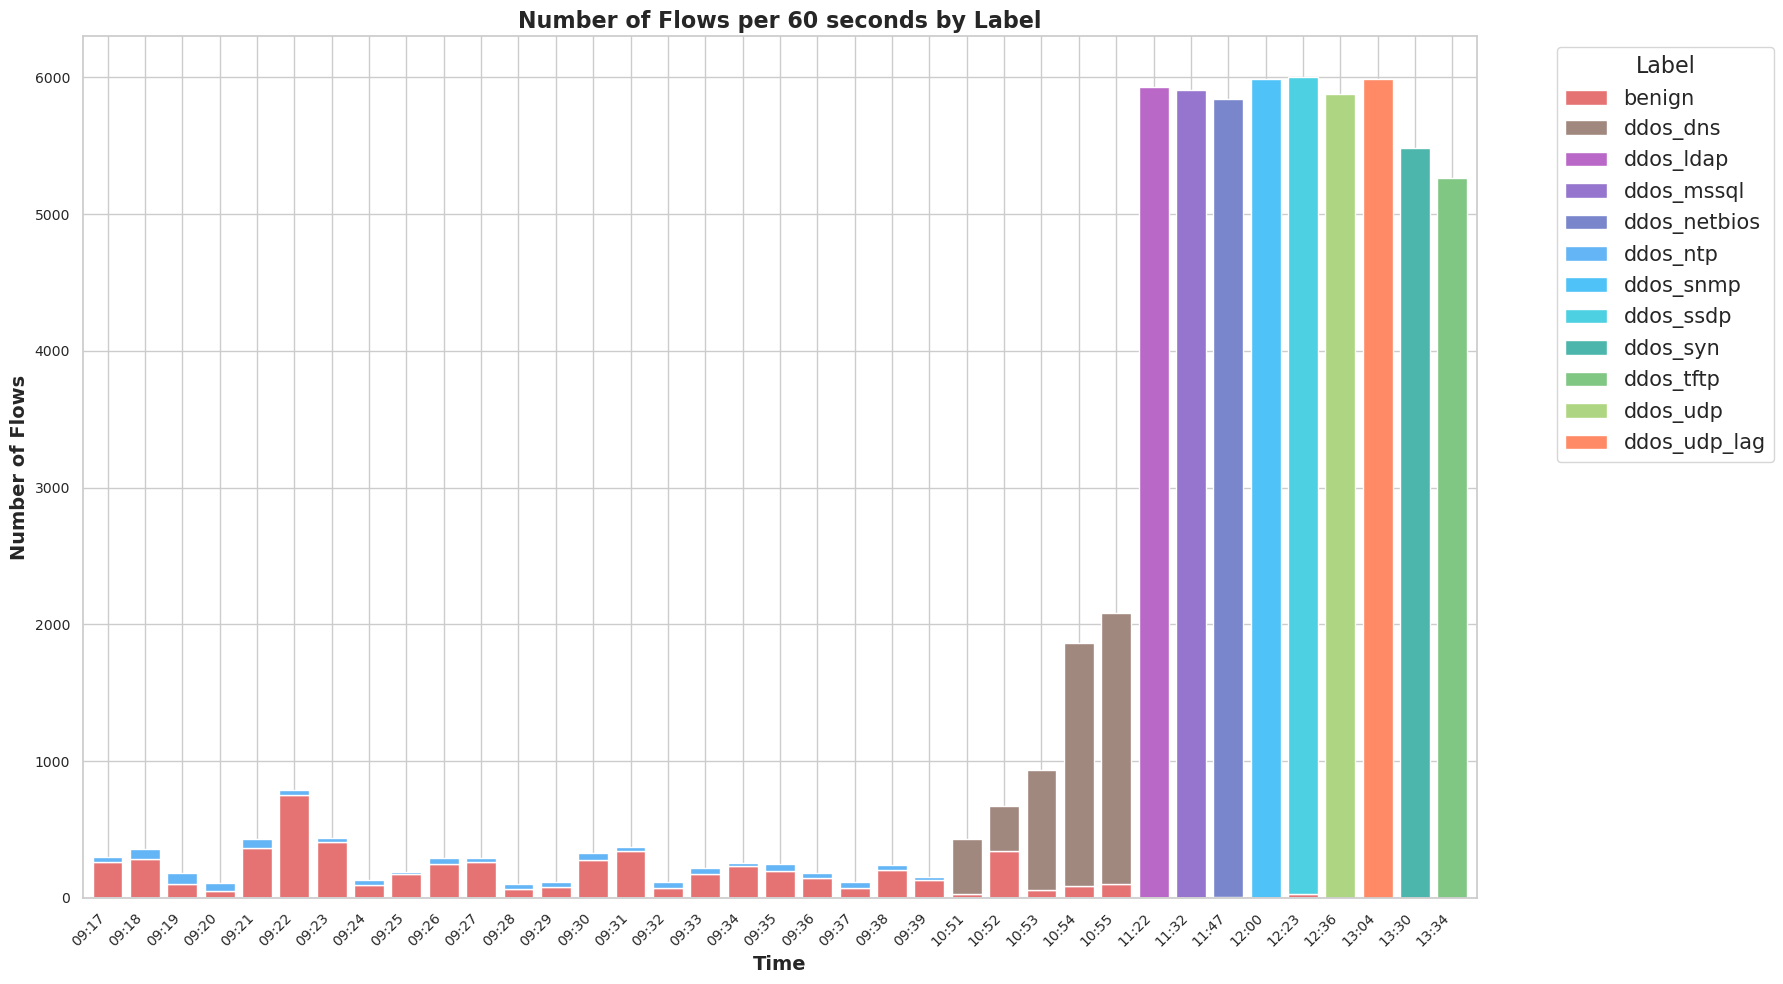

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

sns.set(style="whitegrid")

ddos_data_cp = ddos_data.copy()
ddos_data_cp = ddos_data_cp.reset_index()

ddos_data_cp['Timestamp'] = pd.to_datetime(ddos_data_cp['Timestamp'])
ddos_data_cp.set_index('Timestamp', inplace=True)

num_sec = 60
df_result = ddos_data_cp.groupby([pd.Grouper(freq=f'{num_sec}S'), 'label']).count()['Flow ID'].unstack(fill_value=0)

# Define a list of colors for categories.
colors = ['#e57373', '#a1887f', '#ba68c8', '#9575cd', '#7986cb',
          '#64b5f6', '#4fc3f7', '#4dd0e1', '#4db6ac', '#81c784', 
          '#aed581', '#ff8a65']



fig, ax = plt.subplots(figsize=(18, 10)) 
df_result.plot(kind='bar', stacked=True, width=0.8, color=colors[:len(df_result.columns)], ax=ax)

ax.set_xlabel('Time', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Flows', fontsize=14, fontweight='bold')
ax.set_title('Number of Flows per 60 seconds by Label', fontsize=16, fontweight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 

timestamp_labels = df_result.index.strftime('%H:%M')  
ax.set_xticklabels(timestamp_labels)  


handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, title='Label', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)
legend.get_title().set_fontsize('16') 

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


### ECDF of total length of forwared packets

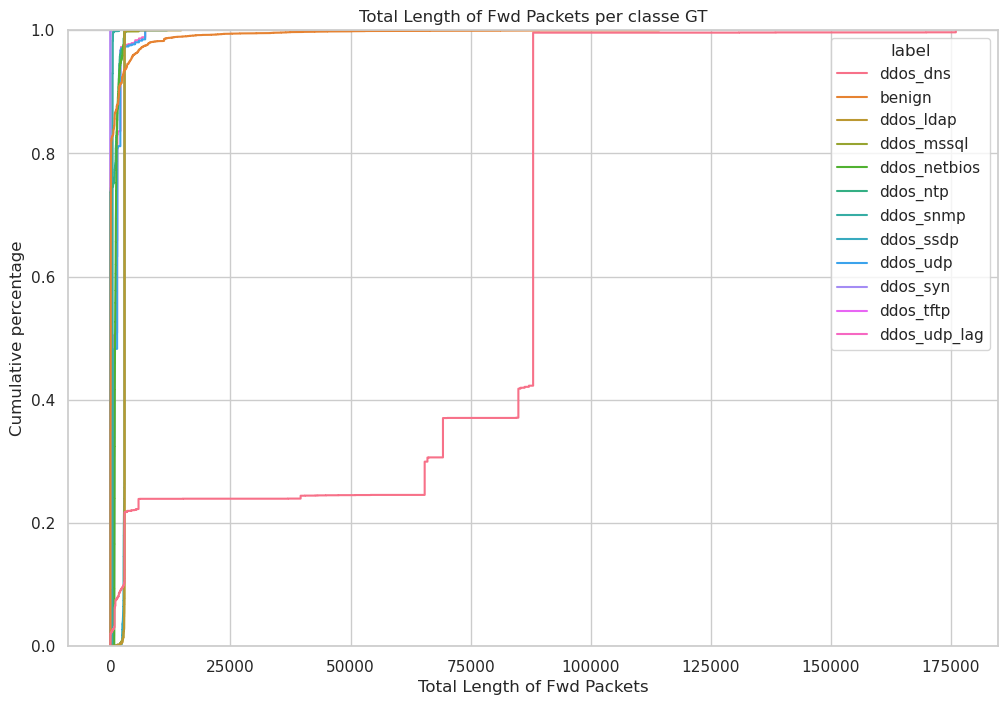

In [28]:
plt.figure(figsize=(12, 8))
sns.ecdfplot(x='Total Length of Fwd Packets', data=ddos_data, hue='label')
plt.title('Total Length of Fwd Packets per classe GT')
plt.xlabel('Total Length of Fwd Packets')
plt.ylabel('Cumulative percentage')
plt.show()

**ECDF (Empirical Cumulative Distribution Function) of the total duration of fwd packets**<br>
(the total length, in bytes, of the packets sent from the source to the destination), useful for understanding how the majority of attacks utilize almost 100% the same packet size, while others (such as ddos_dns) employ packets of significantly different and variable sizes.

## Feature Engineering

#### add feaures hours, minutes, seconds, milliseconds


In [29]:
"""
# Add hours, minutes, seconds, and milliseconds 
ddos_data_cp = ddos_data.copy()
ddos_data_cp['Timestamp'] = pd.to_datetime(ddos_data_cp['Timestamp'])

# Extract hours, minutes, seconds, and milliseconds from the 'Timestamp' column
ddos_data_cp['hours'] = ddos_data_cp['Timestamp'].dt.hour
ddos_data_cp['minutes'] = ddos_data_cp['Timestamp'].dt.minute
ddos_data_cp['seconds'] = ddos_data_cp['Timestamp'].dt.second
# For milliseconds, first we calculate the difference in microseconds (dt.microsecond) and then divide by 1000 to get milliseconds.
ddos_data_cp['milliseconds'] = ddos_data_cp['Timestamp'].dt.microsecond // 1000
"""

"\n# Add hours, minutes, seconds, and milliseconds \nddos_data_cp = ddos_data.copy()\nddos_data_cp['Timestamp'] = pd.to_datetime(ddos_data_cp['Timestamp'])\n\n# Extract hours, minutes, seconds, and milliseconds from the 'Timestamp' column\nddos_data_cp['hours'] = ddos_data_cp['Timestamp'].dt.hour\nddos_data_cp['minutes'] = ddos_data_cp['Timestamp'].dt.minute\nddos_data_cp['seconds'] = ddos_data_cp['Timestamp'].dt.second\n# For milliseconds, first we calculate the difference in microseconds (dt.microsecond) and then divide by 1000 to get milliseconds.\nddos_data_cp['milliseconds'] = ddos_data_cp['Timestamp'].dt.microsecond // 1000\n"

#### one-hot of Protocol

In [30]:
# Create boolean masks for each protocol.
mask_udp = ddos_data_cp['Protocol'] == 0
mask_tcp = ddos_data_cp['Protocol'] == 6
mask_hopopt = ddos_data_cp['Protocol'] == 17

# Converts Boolean masks to integer columns (1 for True, 0 for False)
ddos_data_cp['Protocol 0'] = mask_udp.astype(int)
ddos_data_cp['Protocol 6'] = mask_tcp.astype(int)
ddos_data_cp['Protocol 17'] = mask_hopopt.astype(int)


## Data Scaling or Standardization

In [31]:
ddos_data_temp = ddos_data.copy()

# Drop non-numeric and non-essential columns from the copied DataFrame
ddos_data_temp.drop(
    columns=["Destination IP", "Source IP", "Source Port", "Destination Port", "Timestamp", "Protocol", "SimillarHTTP" ], 
    axis=1, 
    inplace=True)

x = ddos_data_temp.drop(columns=['label'])
y = ddos_data_temp[['label']]

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, train_size=0.7, random_state=15)
y_train, y_test = np.ravel(y_train), np.ravel(y_test)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_s, x_test_s = scaler.transform(x_train), scaler.transform(x_test)

ddos_data_x_train_s = pd.DataFrame(x_train_s, columns=x_train.columns)
ddos_data_x_test_s = pd.DataFrame(x_test_s, columns=x_test.columns)
ddos_data_s = ddos_data_x_train_s.copy()

## Correlation Analysis and Dimensionality Reduction


##### Pearson's correlation analysis

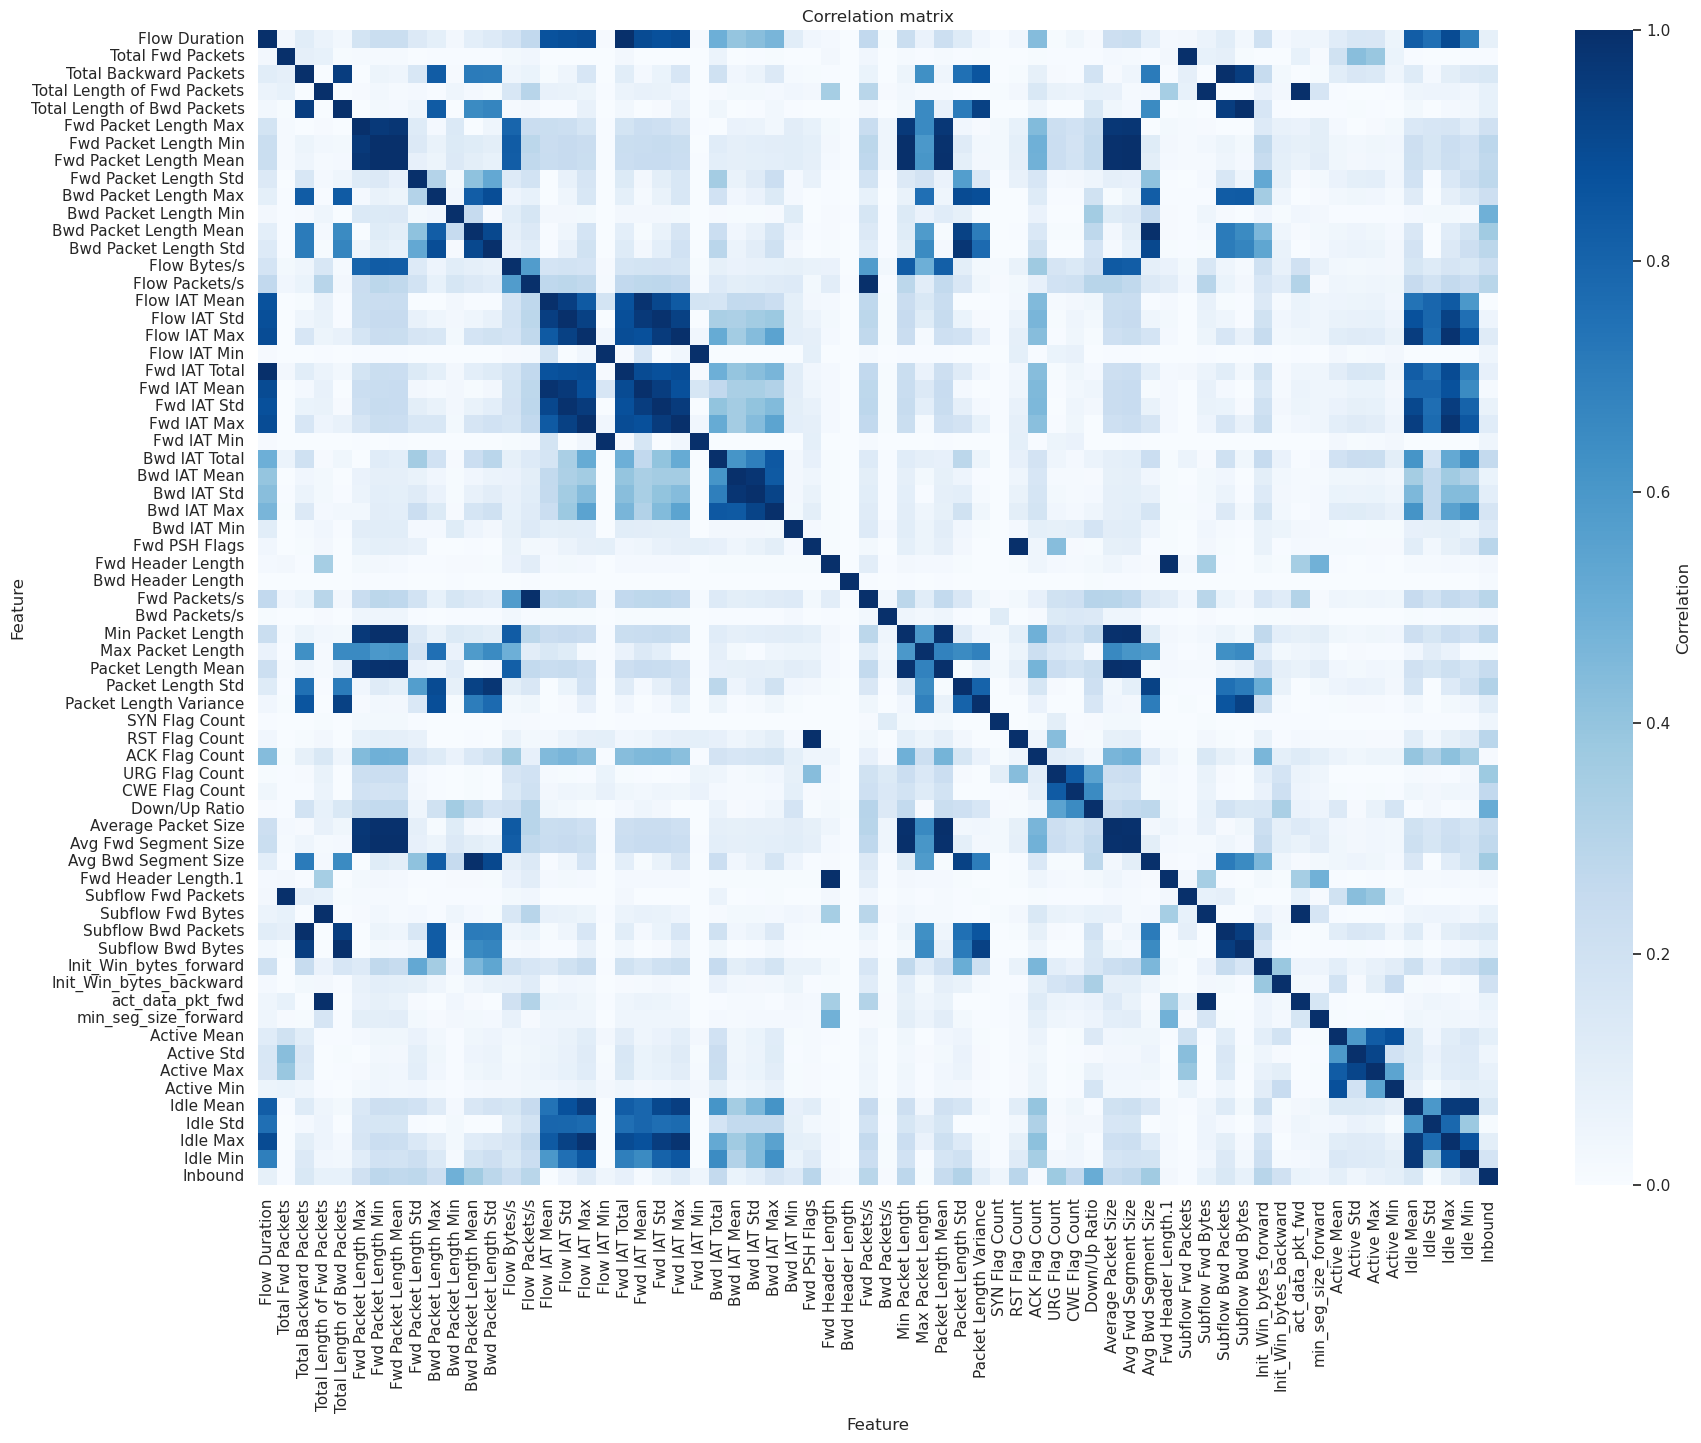

In [32]:
correlation_matrix_pearson = ddos_data_s.corr(method='pearson').abs()

# correlation pearson matrix heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix_pearson, cmap='Blues', vmin=.0, vmax=1, cbar_kws={'label': 'Correlation'}, fmt='.2f')
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation matrix')
plt.show()

##### Feature selection
The aim is to remove features that are highly correlated with each other, as such features can lead to redundancy and multicollinearity problems in models. 

In [33]:
# Extract features having a correlation > 0.85
c = correlation_matrix_pearson[correlation_matrix_pearson > 0.85]
s = c.unstack()
so = s.sort_values(ascending=False).reset_index()

# Get strongly correlatead features, removing pairs having correlation = 1 because of the diagonal, i.e., correlation between one feature and itself
so = so[(so[0].isnull() == False) & (so["level_0"] != so["level_1"])]
to_be_deleted_pearson = []
candidates = list(so["level_0"])

# Get the unique set of features to be deleted
# Notice that we discard one feature per time considering the case where a feature is strongly correlated with multiple features
subset_so = so
for candidate in candidates:
    if (candidate in list(subset_so["level_0"])):
        to_be_deleted_pearson.append(candidate)  # add the feature to the removed candidates
        subset_so = subset_so[(subset_so["level_0"] != candidate) & (
                    subset_so["level_1"] != candidate)]  # remove the rows that the removed feature is involved

print(len(to_be_deleted_pearson), 'features to be removed')
print(sorted(to_be_deleted_pearson))


34 features to be removed
['Active Max', 'Active Mean', 'Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size', 'Bwd IAT Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Min', 'Flow IAT Std', 'Fwd Header Length', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Total', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Fwd Packets/s', 'Idle Max', 'Idle Mean', 'Min Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'RST Flag Count', 'Subflow Bwd Bytes', 'Subflow Bwd Packets', 'Subflow Fwd Bytes', 'Subflow Fwd Packets', 'Total Backward Packets', 'Total Length of Bwd Packets', 'Total Length of Fwd Packets']


34 features to be removed
['Active Max', 'Active Mean', 'Average Packet Size', 'Avg Bwd Segment Size', 'Avg Fwd Segment Size', 'Bwd IAT Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Min', 'Flow IAT Std', 'Fwd Header Length', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Total', 'Fwd Packet Length Mean', 'Fwd Packet Length Min', 'Fwd Packets/s', 'Idle Max', 'Idle Mean', 'Min Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'RST Flag Count', 'Subflow Bwd Bytes', 'Subflow Bwd Packets', 'Subflow Fwd Bytes', 'Subflow Fwd Packets', 'Total Backward Packets', 'Total Length of Bwd Packets', 'Total Length of Fwd Packets']

##### PCA

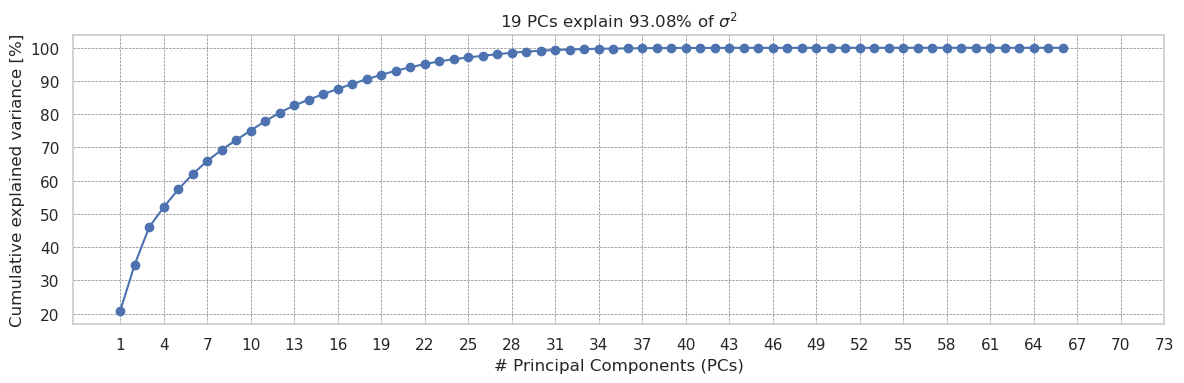

In [34]:
# Initialize PCA with a set random state for reproducibility
pca = PCA(random_state=15)
# Fit the PCA model to the ddos_data_x dataset to determine the principal components
pca.fit(ddos_data_s)
# Retrieve the explained variance ratio of each principal component
explained_variance = pca.explained_variance_ratio_
# Calculate the cumulative explained variance across all principal components
cumul_exp_var = np.cumsum(explained_variance)
# Convert the cumulative explained variance to percentage format
perc_cumul_exp_var = cumul_exp_var * 100


# Plot the cumulative explained variance percentage as a function of the number of principal components
plt.figure(figsize=(12, 4))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks(np.arange(0, 74, 3), np.arange(1, 75, 3))
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.title(f'19 PCs explain {round(perc_cumul_exp_var[19], 2)}% of $\\sigma^2$')
plt.tight_layout()
plt.show()

#### Loading Score

For the purpose of comparing the selected values through correlation analysis, the weights of the features in the first three components will be visualized.

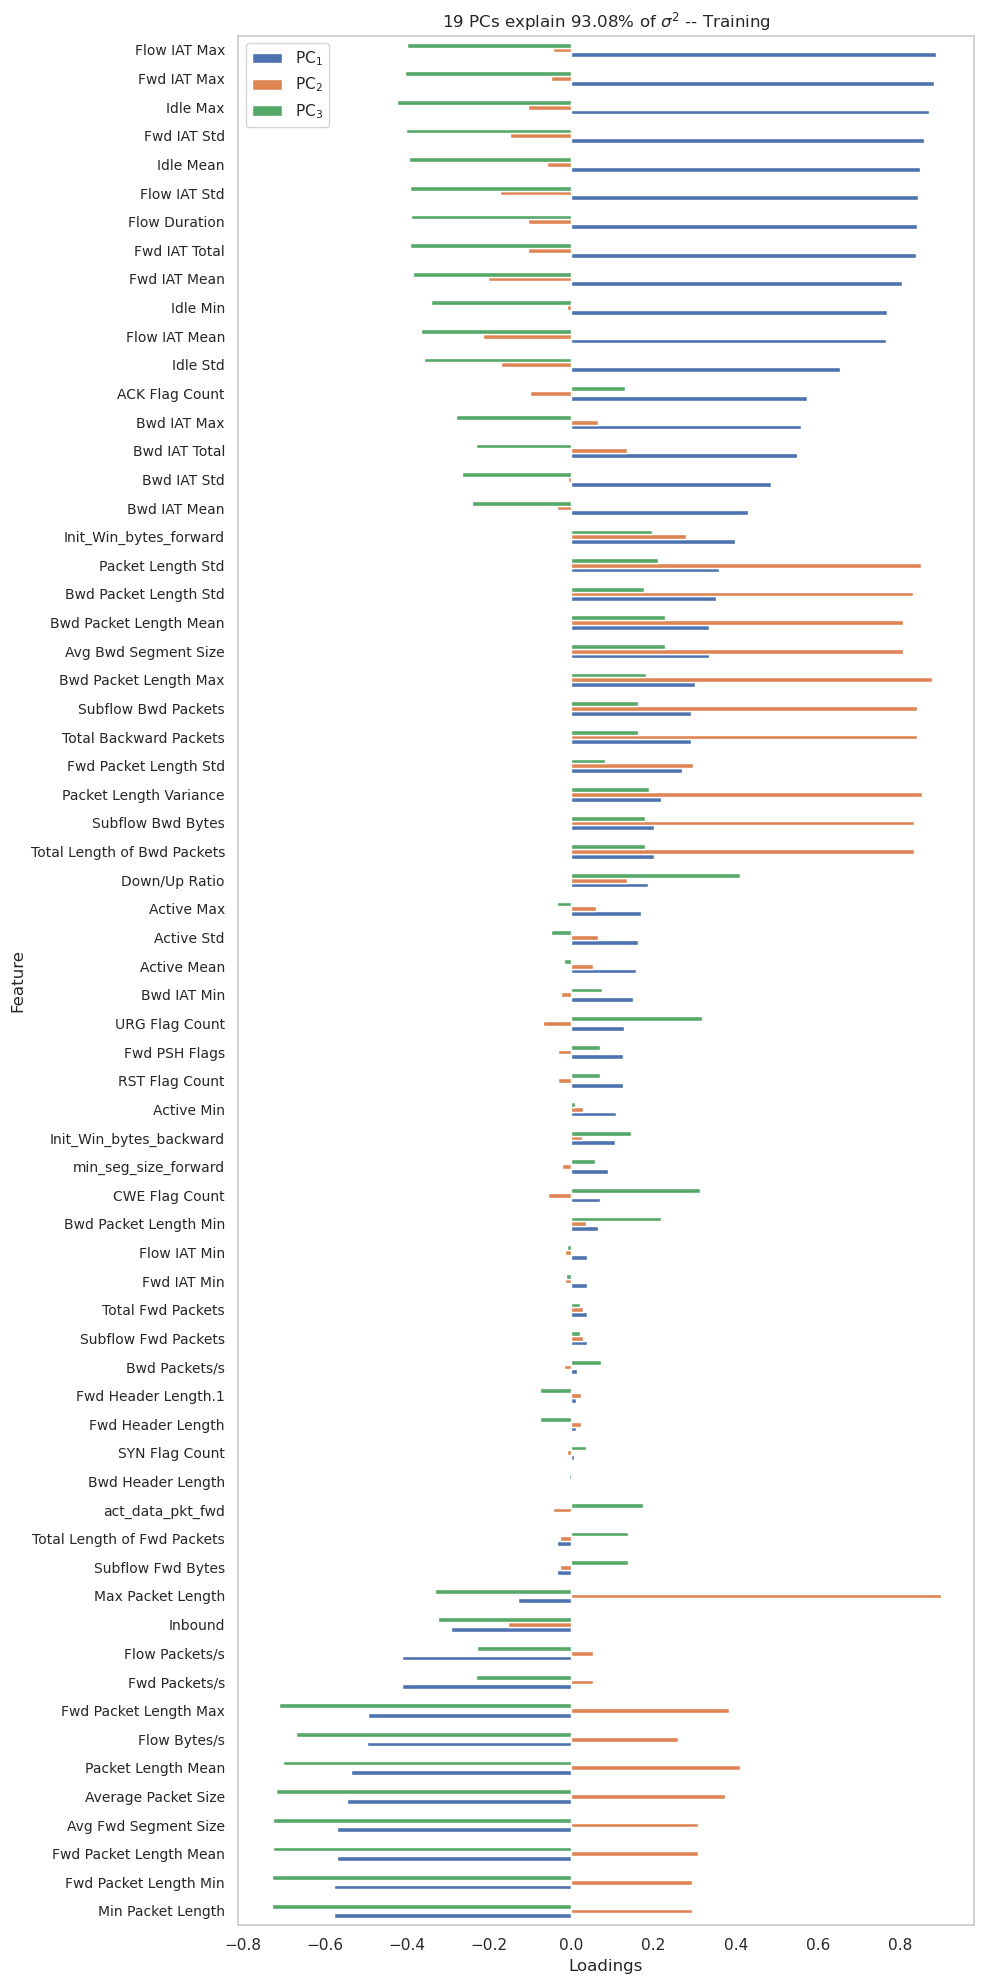

In [35]:
# Compute the loading scores
loadings = pd.DataFrame(
    data = pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns = [f'PC{i}' for i in range(1, 67)],
    index = ddos_data_s.columns
)

plt.figure(figsize=(10, 20))
loadings = loadings[['PC1', 'PC2', 'PC3']]
loadings.sort_values(['PC1', 'PC2', 'PC3']).rename(columns={'PC1':'PC$_{1}$', 'PC2':'PC$_{2}$', 'PC3':'PC$_{3}$'}).plot.barh(ax=plt.gca())
plt.grid()
plt.xlabel('Loadings')
plt.ylabel('Feature')
plt.yticks(fontsize=10)
plt.title(f'19 PCs explain {round(perc_cumul_exp_var[19], 2)}% of $\sigma^2$ -- Training')
plt.tight_layout()
plt.show()
